In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [1]:
!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2023-10-30 08:49:37--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.158.61.10, 108.158.61.61, 108.158.61.125, ...
Connecting to segment-anything.com (segment-anything.com)|108.158.61.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   389KB/s    in 0.6s    

2023-10-30 08:49:39 (389 KB/s) - ‘dog.jpg’ saved [221810/221810]



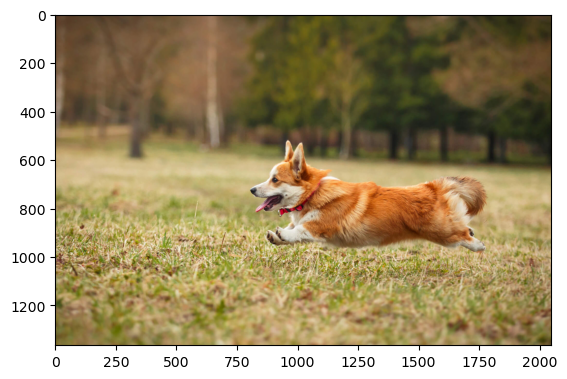

In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")

# Show the image
plt.imshow(img.permute(1, 2, 0))

In [4]:
img

tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         ...,
         [121, 121, 122,  ...,  97,  96,  96],
         [121, 121, 122,  ...,  97,  97,  96],
         [121, 121, 122,  ...,  98,  97,  97]],

        [[ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         ...,
         [103, 103, 104,  ...,  82,  81,  81],
         [103, 103, 104,  ...,  82,  82,  81],
         [103, 103, 104,  ...,  83,  82,  82]],

        [[ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         ...,
         [ 37,  37,  38,  ...,  43,  42,  42],
         [ 37,  37,  38,  ...,  43,  43,  42],
         [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8)

In [5]:
# [0, 1] the image
img = img / 255.0

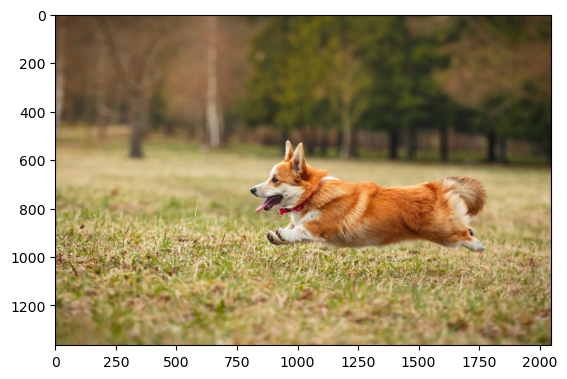

In [6]:
plt.imshow(img.permute(1, 2, 0))

In [7]:
img.shape

torch.Size([3, 1365, 2048])

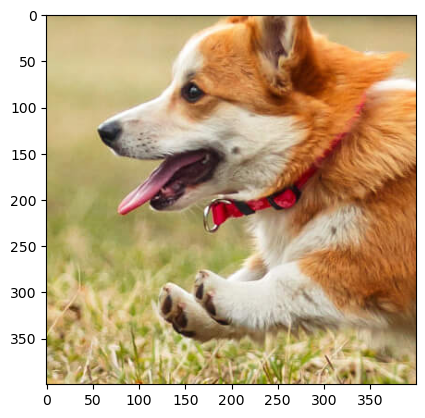

In [8]:
crop = torchvision.transforms.functional.crop(img, 600, 750, 400, 400)


# Plot the crop
plt.imshow(crop.permute(1, 2, 0))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
img

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [11]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [ ]:
# Create a coordinate dataset from the image
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """
    
    num_channels, height, width = crop.shape
    
    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)
    
    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    
    # Create a tensor containing the image pixel values
    Y = img.reshape(num_channels, -1).float().to(device)
    return X, Y
    

    
    

In [3]:
from astra.torch.data import load_mnist
ds, ds_name = load_mnist()

In [4]:
ds

<xarray.Dataset>
Dimensions:  (sample: 70000, channel: 1, x: 28, y: 28)
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 ... 69994 69995 69996 69997 69998 69999
  * channel  (channel) int64 0
  * x        (x) int64 27 26 25 24 23 22 21 20 19 18 17 ... 9 8 7 6 5 4 3 2 1 0
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 18 19 20 21 22 23 24 25 26 27
Data variables:
    img      (sample, channel, x, y) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    label    (sample) float32 5.0 0.0 4.0 1.0 9.0 2.0 ... 2.0 3.0 4.0 5.0 6.0

In [7]:
ds.info()

xarray.Dataset {
dimensions:
	sample = 70000 ;
	channel = 1 ;
	x = 28 ;
	y = 28 ;

variables:
	float32 img(sample, channel, x, y) ;
	float32 label(sample) ;
	int64 sample(sample) ;
	int64 channel(channel) ;
	int64 x(x) ;
	int64 y(y) ;

// global attributes:
}

In [15]:
images = ds['img'][:100].values

# Convert the NumPy array to a PyTorch tensor
images_tensor = torch.from_numpy(images)

In [16]:
images_tensor.shape

torch.Size([100, 1, 28, 28])

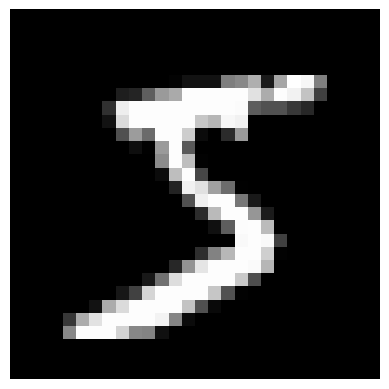

In [18]:
# Plot ith image
def plot_image(i):
    plt.imshow(images_tensor[i].reshape(28, 28), cmap='gray')
    # Remove the axis
    plt.axis('off')
    plt.show()

plot_image(0)

In [20]:
im = images_tensor[0].reshape(28, 28)
im.shape

torch.Size([28, 28])

In [28]:
xi, yi = torch.meshgrid(torch.arange(28), torch.arange(28))
xi.shape

torch.Size([28, 28])

In [30]:
xi.reshape(-1, 1).shape

torch.Size([784, 1])

In [23]:
im.view(-1, 28*28)

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  

In [34]:
def convert_coordinate(image):
    flat_im = image.view(-1)

    # Create (x, y) coordinate pairs
    x_coords, y_coords = torch.meshgrid(torch.arange(28), torch.arange(28))

    # Flatten the coordinates as well
    # Flatten the coordinates as well
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    # Stack the (x, y) coordinates with the flattened image
    coordinates = torch.stack((x_coords, y_coords), dim=1)

    return coordinates, flat_im

In [35]:
convert_coordinate(im)

(tensor([[ 0,  0],
         [ 0,  1],
         [ 0,  2],
         ...,
         [27, 25],
         [27, 26],
         [27, 27]]),
 tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0

In [ ]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

class NN(nn.Module):
    def __init__(self, activation=torch.sin, n_out=1):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, n_out) #gray scale image (1) or RGB (3)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        return self.fc6(x)

In [ ]:
nn_relu = NN(activation=F.relu)

nn_relu.activation

<function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>

In [ ]:
nn_relu(convert_coordinate(im)[0])

TypeError: relu() missing 1 required positional argument: 'input'

In [49]:
def train(model, image, epochs=1000, lr=0.01):
    # Convert the image to (x, y) coordinates and pixel values
    coordinates, pixel_values = convert_coordinate(image)

    # Define the loss function
    loss_fn = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    for i in range(epochs):
        # Forward pass
        pred = model(coordinates)
        print(pred.shape)
        

        # Compute the loss
        loss = loss_fn(pred, pixel_values)

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch: {i}, Loss: {loss.item():.4f}')

In [50]:
train(nn_relu, im)

RuntimeError: mat1 and mat2 must have the same dtype